# Nowcast evaluation

In [1]:
import sys
sys.path.append('../')
from src.scoring_functions import *
from src.realtime_utils import *
from src.load_data import *
from plotnine import *

In [2]:
model_names = {
    'KIT-MeanEnsemble' : 'Ensemble',
    'lightgbm2' : 'LightGBM-Old',
    'lightgbm23' : 'LightGBM',
    'lightgbm_skip': 'LightGBM-Skip',
    'lightgbm_retrain': 'LightGBM-Retrain',
    'lightgbm_precov': 'LightGBM-PreCov',
    'tsmixer' : 'TSMixer',
    'tsmixer_retrain': 'TSMixer-Retrain',
    'tsmixer_precov': 'TSMixer-PreCov',
    'KIT-hhh4' : 'hhh4',
    'KIT-hhh4_all_data': 'hhh4_all_data',
    'KIT-hhh4_all_data_skip': 'hhh4_all_data_skip',
    'KIT-baseline' : 'Nowcast',
    'KIT-persistence': 'Baseline-Persistence',
    'baseline' : 'Baseline-Historical'
}

In [3]:
model_colors = {
    "LightGBM": "#B30000",
    "TSMixer": "#E69F00",
    'TSMixer-Retrain': "#E69F00",
    'TSMixer-PreCov': "#E69F00",
    "LightGBM-Retrain": "#999999",
    "Nowcast": "#56B4E9",
    "hhh4_all_data": "#F0E442",
    "Ensemble": "#009E73",
    'LightGBM-PreCov': "#60D1B3",
    "Baseline-Historical": "#80471C",
    'Baseline-Persistence' : "#80471C",
    "hhh4": "#3C4AAD",
    "hhh4_all_data_skip": "#CC79A7",
    "LightGBM-Skip": "#000000"
}

In [4]:
def load_nowcasts(start='2023-12-14', end='2024-09-19', include_truth=True):
    files = glob.glob(f'../data/nowcasts/KIT-baseline/*.csv') 

    dfs = []
    for file in files:
        df_temp = pd.read_csv(file)
        df_temp['model'] = file[:-4].split('/')[-1].split('-', 5)[-1]
        dfs.append(df_temp)
    df = pd.concat(dfs)
    
    df = df[df.forecast_date.between(start, end)].reset_index(drop=True)
    
    if include_truth:
        df = add_truth(df, target=True)
    
    return df

In [5]:
df_nowcasts = load_nowcasts()

In [6]:
df = load_predictions('post-covid')

In [7]:
MODELS = ['lightgbm_retrain','lightgbm_precov', 
          'tsmixer_retrain', 'tsmixer_precov', 
          'baseline', 'KIT-persistence',
          'KIT-hhh4_all_data', 'KIT-hhh4',
          'KIT-MeanEnsemble']

In [8]:
df = df[~df.model.isin(['lightgbm', 'lightgbm2'])]

In [9]:
df = df[df.model.isin(MODELS)]

In [10]:
df.model.unique()

array(['tsmixer_precov', 'tsmixer_retrain', 'lightgbm_retrain',
       'baseline', 'KIT-persistence', 'KIT-hhh4_all_data',
       'KIT-MeanEnsemble', 'KIT-hhh4', 'lightgbm_precov'], dtype=object)

In [11]:
df = pd.concat([df, df_nowcasts], ignore_index=True)

In [17]:
df = df[df['quantile'].isin([0.025, 0.1, 0.25, 0.5, 0.75, 0.9, 0.975])]

In [12]:
df.model = df.model.replace(model_names)

In [13]:
df = df[df.forecast_date != '2023-12-28']

In [14]:
# df = df[df.target_end_date.between('2023-01-04', '2024-09-15')].reset_index(drop=True)

In [15]:
df = df[df.forecast_date.between('2023-11-16', '2024-09-15')].reset_index(drop=True)

In [16]:
df.target_end_date.max()

'2024-10-06'

In [110]:
def evaluate_models(df, level=None, by_horizon=False, by_age=False):
    if level is not None:
        df_temp = filter_by_level(df, level)
    else:
        df_temp = df
    if by_horizon:
        wis_temp = df_temp.groupby('horizon')[df_temp.columns].apply(compute_wis).reset_index().drop(columns='level_1')
        coverage_temp = df_temp.groupby('horizon')[df_temp.columns].apply(compute_coverage).reset_index().drop(columns='level_1')
        results = wis_temp.merge(coverage_temp, on=['model', 'horizon']).sort_values(['horizon', 'wis'], ignore_index=True)
    elif by_age:
        wis_temp = df_temp.groupby('age_group')[df_temp.columns].apply(compute_wis).reset_index().drop(columns='level_1')
        coverage_temp = df_temp.groupby('age_group')[df_temp.columns].apply(compute_coverage).reset_index().drop(columns='level_1')
        results = wis_temp.merge(coverage_temp, on=['model', 'age_group']).sort_values(['age_group', 'wis'], ignore_index=True)        
    else:
        wis_temp = compute_wis(df_temp)
        coverage_temp = compute_coverage(df_temp)
        results = wis_temp.merge(coverage_temp, on='model').sort_values('wis', ignore_index=True)
    
    return results

In [111]:
evaluate_models(df)

,model,spread,overprediction,underprediction,wis,c50,c95
0,Nowcast,35.435099,54.200197,27.653118,117.288415,0.384615,0.831502
1,Ensemble,127.101294,67.988300,136.422333,331.511927,0.419414,0.934066
2,LightGBM-Retrain,112.765575,38.711156,203.941335,355.418066,0.374542,0.831502
3,TSMixer-Retrain,153.925747,109.068789,93.431413,356.425948,0.502747,0.891941
4,LightGBM-PreCov,125.367106,36.212633,196.273719,357.853459,0.336081,0.832418
5,hhh4_all_data,159.211146,121.968210,98.672030,379.851387,0.544872,0.949634
6,hhh4,140.484040,142.223574,134.793433,417.501047,0.466117,0.902930
7,Baseline-Persistence,186.182732,219.971873,82.078755,488.233359,0.472527,0.821429
8,Baseline-Historical,148.813300,8.420436,434.195670,591.429406,0.257722,0.608108
9,TSMixer-PreCov,69.755793,71.916279,537.548995,679.221066,0.116300,0.391026


In [116]:
355/380

0.9342105263157895

# Compute scores

#### National level

In [18]:
evaluate_models(df, 'national')

,model,spread,overprediction,underprediction,wis,c50,c95
0,Nowcast,109.999725,118.502747,39.896520,268.398993,0.435897,0.955128
1,Ensemble,430.839795,190.168974,351.560331,972.569100,0.532051,0.974359
2,TSMixer-Retrain,486.354212,324.639093,244.470261,1055.463566,0.621795,0.955128
3,LightGBM-Retrain,386.389532,58.262293,671.696012,1116.347837,0.576923,0.929487
4,LightGBM-PreCov,382.186124,48.427321,761.053579,1191.667024,0.243590,0.929487
5,hhh4_all_data,419.775641,429.676740,368.754579,1218.206960,0.429487,0.878205
6,hhh4,352.234432,456.717949,601.775641,1410.728022,0.262821,0.737179
7,Baseline-Persistence,677.086126,707.598901,214.660256,1599.345284,0.615385,0.903846
8,Baseline-Historical,458.267954,12.857143,1600.589768,2071.714865,0.189189,0.506757
9,TSMixer-PreCov,195.954265,209.103069,2054.045906,2459.103240,0.044872,0.179487


In [113]:
evaluate_models(df, 'national')

,model,spread,overprediction,underprediction,wis,c50,c95
0,Nowcast,109.999725,118.502747,39.896520,268.398993,0.435897,0.955128
1,Ensemble,378.044283,181.284409,487.454118,1046.782809,0.333333,0.955128
2,TSMixer-Retrain,486.354212,324.639093,244.470261,1055.463566,0.621795,0.955128
3,LightGBM-Retrain,386.389532,58.262293,671.696012,1116.347837,0.576923,0.929487
4,LightGBM-PreCov,382.186124,48.427321,761.053579,1191.667024,0.243590,0.929487
5,hhh4_all_data,419.775641,429.676740,368.754579,1218.206960,0.429487,0.878205
6,hhh4,352.234432,456.717949,601.775641,1410.728022,0.262821,0.737179
7,Baseline-Persistence,677.086126,707.598901,214.660256,1599.345284,0.615385,0.903846
8,Baseline-Historical,458.267954,12.857143,1600.589768,2071.714865,0.189189,0.506757
9,TSMixer-PreCov,195.954265,209.103069,2054.045906,2459.103240,0.044872,0.179487


In [71]:
evaluate_models(df, 'national')

,model,spread,overprediction,underprediction,wis,c50,c95
0,Nowcast,108.599241,115.741071,39.875893,264.216205,0.443750,0.956250
1,Ensemble,379.725849,188.535785,493.019263,1061.280897,0.333333,0.953333
2,TSMixer-Retrain,492.271246,337.624657,244.053643,1073.949546,0.620000,0.953333
3,LightGBM-Retrain,390.738522,60.592784,683.954748,1135.286054,0.586667,0.926667
4,LightGBM,383.276218,45.634760,723.740799,1152.651777,0.506667,0.933333
5,LightGBM-PreCov,390.739162,50.364414,716.633962,1157.737537,0.253333,0.926667
6,TSMixer,429.783552,316.963840,414.635035,1161.382427,0.373333,0.900000
7,LightGBM-Skip,345.496429,47.644957,844.171537,1237.312923,0.406667,0.893333
8,hhh4_all_data,421.261905,446.017143,380.662857,1247.941905,0.406667,0.873333
9,hhh4_all_data_skip,443.280612,379.345918,589.292857,1411.919388,0.221429,0.835714


In [15]:
# evaluate_models(df, 'national', by_horizon=True)

#### Age groups

In [20]:
evaluate_models(df, 'age')

,model,spread,overprediction,underprediction,wis,c50,c95
0,Nowcast,16.958913,27.520299,15.277167,59.756380,0.376068,0.810897
1,Ensemble,93.822105,48.216994,61.159744,203.198843,0.532051,0.958333
2,LightGBM-PreCov,82.563936,34.176852,102.143743,218.884531,0.351496,0.816239
3,LightGBM-Retrain,67.161582,35.452633,125.982222,228.596438,0.340812,0.815171
4,TSMixer-Retrain,98.521003,73.140404,68.258272,239.919678,0.482906,0.881410
5,hhh4_all_data,115.783730,70.683455,53.658272,240.125458,0.564103,0.961538
6,hhh4,105.192308,89.807845,56.963065,251.963217,0.500000,0.930556
7,Baseline-Persistence,104.365499,138.700702,59.981838,303.048039,0.448718,0.807692
8,Baseline-Historical,97.237524,7.680985,239.796654,344.715162,0.269144,0.625000
9,TSMixer-PreCov,48.722714,49.051813,284.799510,382.574038,0.128205,0.426282


In [114]:
evaluate_models(df, 'age')

,model,spread,overprediction,underprediction,wis,c50,c95
0,Nowcast,16.958913,27.520299,15.277167,59.756380,0.376068,0.810897
1,Ensemble,85.277462,49.105616,77.917036,212.300113,0.433761,0.930556
2,LightGBM-PreCov,82.563936,34.176852,102.143743,218.884531,0.351496,0.816239
3,LightGBM-Retrain,67.161582,35.452633,125.982222,228.596438,0.340812,0.815171
4,TSMixer-Retrain,98.521003,73.140404,68.258272,239.919678,0.482906,0.881410
5,hhh4_all_data,115.783730,70.683455,53.658272,240.125458,0.564103,0.961538
6,hhh4,105.192308,89.807845,56.963065,251.963217,0.500000,0.930556
7,Baseline-Persistence,104.365499,138.700702,59.981838,303.048039,0.448718,0.807692
8,Baseline-Historical,97.237524,7.680985,239.796654,344.715162,0.269144,0.625000
9,TSMixer-PreCov,48.722714,49.051813,284.799510,382.574038,0.128205,0.426282


In [115]:
228/240

0.95

In [72]:
evaluate_models(df, 'age')

,model,spread,overprediction,underprediction,wis,c50,c95
0,Nowcast,16.745461,26.962946,15.259673,58.968080,0.378125,0.814583
1,Ensemble,85.778754,50.509864,78.140914,214.429533,0.433333,0.927778
2,LightGBM-PreCov,84.100791,35.239227,97.432866,216.772883,0.363333,0.815556
3,LightGBM-Retrain,68.138533,36.680470,126.000808,230.819810,0.341111,0.818889
4,LightGBM,67.579219,32.582348,140.133366,240.294934,0.316667,0.788889
5,hhh4_all_data,115.745238,72.573333,54.686508,243.005079,0.556667,0.960000
6,TSMixer-Retrain,99.509840,75.862505,69.121302,244.493648,0.473333,0.876667
7,LightGBM-Skip,60.691095,31.644871,155.942519,248.278485,0.275556,0.751111
8,hhh4,105.287302,92.259524,58.003492,255.550317,0.495556,0.927778
9,TSMixer,90.202557,66.080113,115.522073,271.804742,0.362222,0.764444


In [14]:
evaluate_models(df, 'age')

,model,spread,overprediction,underprediction,wis,c50,c95
0,Nowcast,16.745461,26.962946,15.259673,58.968080,0.378125,0.814583
1,Ensemble,84.752174,48.076300,80.177349,213.005823,0.428125,0.928125
2,LightGBM-PreCov,81.687517,33.472354,105.220133,220.380004,0.344792,0.816667
3,LightGBM-Retrain,67.161582,35.452633,125.982222,228.596438,0.340812,0.815171
4,LightGBM,66.447442,30.728840,142.103951,239.280232,0.314583,0.784375
5,TSMixer-Retrain,98.521003,73.140404,68.258272,239.919678,0.482906,0.881410
6,LightGBM-Skip,60.216568,30.558628,156.536302,247.311497,0.279915,0.750000
7,hhh4,104.667411,87.976042,59.000149,251.643601,0.498958,0.929167
8,TSMixer,88.654541,63.622844,122.065149,274.342535,0.347917,0.756250
9,hhh4_all_data,128.135629,89.792730,66.441114,284.369473,0.513393,0.947917


In [17]:
# evaluate_models(df, 'age', by_horizon=True)

In [18]:
# evaluate_models(df, 'age', by_age=True)

# Plots

## By horizon

In [21]:
df_national = evaluate_models(df, 'national', by_horizon=True)
df_age = evaluate_models(df, 'age', by_horizon=True)

df_wide = pd.concat([
    df_national.assign(level='national'),
    df_age.assign(level='age')],
    ignore_index=True)

df_long = pd.melt(df_wide, id_vars=['level', 'horizon', 'model'], value_vars=['wis', 'underprediction', 'spread', 'overprediction'], 
                 var_name='metric', value_name='value')

df_long['level'] = pd.Categorical(df_long['level'], categories=['national', 'age'], ordered=True)

In [22]:
model_colors.keys()

dict_keys(['LightGBM', 'TSMixer', 'TSMixer-Retrain', 'TSMixer-PreCov', 'LightGBM-Retrain', 'Nowcast', 'hhh4_all_data', 'Ensemble', 'LightGBM-PreCov', 'Baseline-Historical', 'Baseline-Persistence', 'hhh4', 'hhh4_all_data_skip', 'LightGBM-Skip'])

In [23]:
df_long.model.unique()

array(['Nowcast', 'LightGBM-Retrain', 'Ensemble', 'LightGBM-PreCov',
       'hhh4_all_data', 'hhh4', 'TSMixer-Retrain', 'Baseline-Persistence',
       'TSMixer-PreCov', 'Baseline-Historical'], dtype=object)

In [24]:
def plot_scores_by_horizon_and_model(df, level='national'):
    scores = df[df.level==level].copy()
    
    desired_order = ['Nowcast', 'Ensemble', 'LightGBM-PreCov', 'LightGBM-Retrain', 'TSMixer-Retrain', 'TSMixer-PreCov', 'hhh4', 'hhh4_all_data', 'Baseline-Persistence', 'Baseline-Historical']
    scores['model'] = pd.Categorical(scores['model'], categories=desired_order, ordered=True) 
    
    plot = (
        ggplot() 
        + geom_bar(scores[scores.metric == 'wis'], aes(x='model', y='value', color='model'), fill='white', stat='identity', width=0.7,
                   show_legend=False)
        + geom_bar(scores[scores.metric != 'wis'], aes(x='model', y='value', fill='model', alpha='metric'), size=0.1, stat='identity', width=0.7, 
                   show_legend={'color': False,
                                'fill': False,
                                'alpha': True})
        + scale_color_manual(values=model_colors)
        + scale_fill_manual(values=model_colors)
        + scale_alpha_discrete(labels=["Overprediction", "Spread", "Underprediction"], guide=guide_legend(reverse=False))
        + labs(x="", y="WIS", color="Model", alpha="Decomposition of WIS:", title="WIS by horizon")
        + facet_grid(cols='horizon', scales="free", space='free')  # Create a facet for each horizon
        #+ facet_wrap('~horizon', nrow=1, scales='free_x', space='free')  # Create a facet for each horizon
        + theme_bw()
        + theme(legend_position='bottom',
            legend_title_position='left',
            strip_text=element_text(size=9),             # Facet title text size
            legend_title=element_text(size=9),           # Legend title text size
            legend_text=element_text(size=8),             # Legend item text size
            axis_text_x=element_text(size=9, rotation=90, ha="center"),               # Axis text (tick labels) size
            axis_text_y=element_text(size=9),
            axis_title=element_text(size=10),             # Axis title text size
            plot_title=element_text(size=11)            # Plot title text size)
       )
        #+ coord_flip()
    )
    
    return plot

In [25]:
df_long.model.unique()

array(['Nowcast', 'LightGBM-Retrain', 'Ensemble', 'LightGBM-PreCov',
       'hhh4_all_data', 'hhh4', 'TSMixer-Retrain', 'Baseline-Persistence',
       'TSMixer-PreCov', 'Baseline-Historical'], dtype=object)

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/scales/scale_alpha.py:76: PlotnineWarning: Using alpha for a discrete variable is not advised.


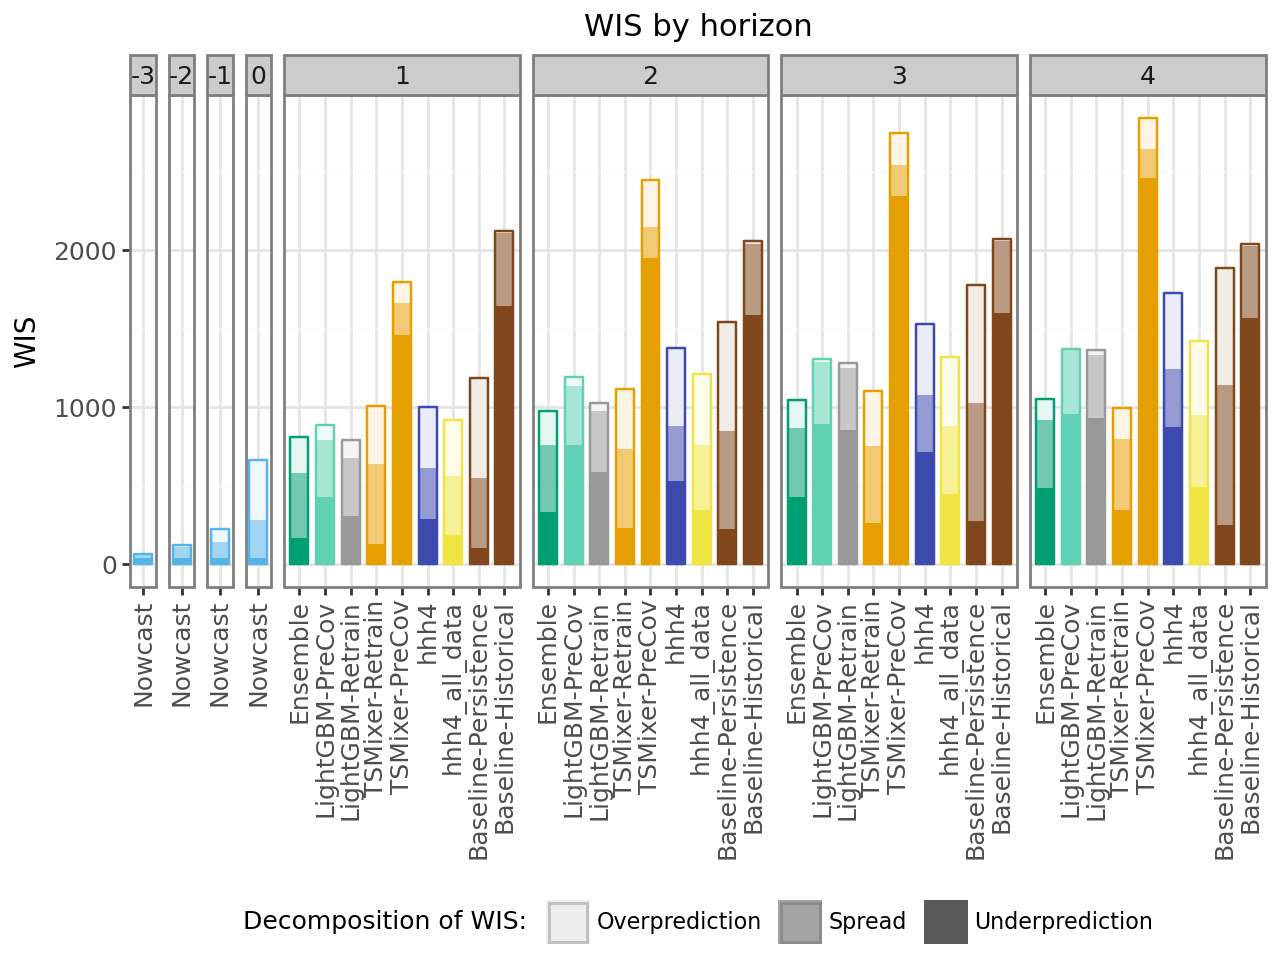

In [26]:
p = plot_scores_by_horizon_and_model(df_long, 'national')
p 

In [39]:
p.save("../figures/wis_with_nowcast.pdf", width = 165, height = 120, units="mm", dpi=600)

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 165.0 x 120.00000000000001 mm image.
/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../figures/wis_with_nowcast.pdf


/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/scales/scale_alpha.py:76: PlotnineWarning: Using alpha for a discrete variable is not advised.


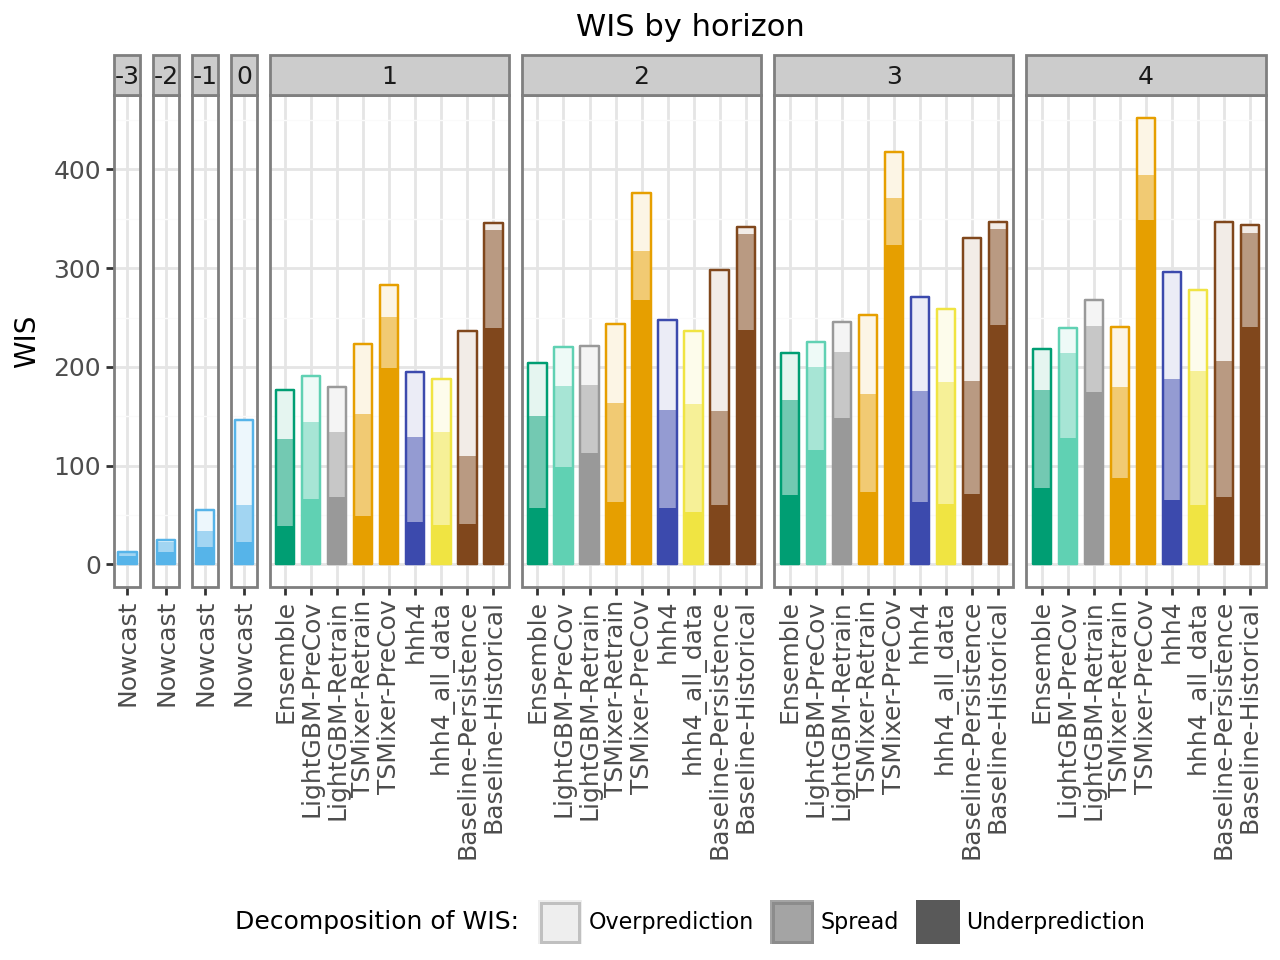

In [27]:
p = plot_scores_by_horizon_and_model(df_long, 'age')
p 

In [41]:
p.save("../figures/wis_with_nowcast_age.pdf", width = 165, height = 120, units="mm", dpi=600)

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 165.0 x 120.00000000000001 mm image.
/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../figures/wis_with_nowcast_age.pdf


In [ ]:
p = plot_scores_by_horizon_and_model(df_long, level='age')
p

In [141]:
p.save("../figures/wis_age_horizon.pdf", width = 160, height = 80, units="mm", dpi=600)

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 160.0 x 80.0 mm image.
/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../figures/wis_age_horizon.pdf


## By age group

In [28]:
df.model.unique()

array(['TSMixer-PreCov', 'TSMixer-Retrain', 'LightGBM-Retrain',
       'Baseline-Historical', 'Baseline-Persistence', 'hhh4_all_data',
       'Ensemble', 'hhh4', 'LightGBM-PreCov', 'Nowcast'], dtype=object)

In [29]:
scores_age = evaluate_models(df[df.model != 'Nowcast'], 'age', by_age=True)

In [30]:
scores_age = pd.melt(scores_age, id_vars=['age_group', 'model'], value_vars=['wis', 'underprediction', 'spread', 'overprediction'], 
                 var_name='metric', value_name='value')

In [31]:
def plot_scores_by_age_group(scores):
    desired_order = ['Nowcast', 'Ensemble', 'LightGBM-PreCov', 'LightGBM-Retrain', 'TSMixer-Retrain', 'TSMixer-PreCov', 'hhh4', 'hhh4_all_data', 'Baseline-Persistence', 'Baseline-Historical']
    scores['model'] = pd.Categorical(scores['model'], categories=desired_order, ordered=True) 
    
    plot = (
        ggplot() 
        + geom_bar(scores[scores.metric == 'wis'], aes(x='model', y='value', color='model'), fill='white', stat='identity', width=0.7,
                   show_legend=False)
        + geom_bar(scores[scores.metric != 'wis'], aes(x='model', y='value', fill='model', alpha='metric'), size=0.1, stat='identity', width=0.7, 
                   show_legend={'color': False,
                                'fill': False,
                                'alpha': True})
        + scale_color_manual(values=model_colors)
        + scale_fill_manual(values=model_colors)
        + scale_alpha_discrete(labels=["Overprediction", "Spread", "Underprediction"], guide=guide_legend(reverse=False))
        + labs(x="", y="WIS", color="Model", alpha="Decomposition\nof WIS:", title="")
        + facet_wrap('~age_group')
        + theme_bw()
        + theme(legend_position='right',
            legend_title_position='top',
            strip_text=element_text(size=10),             # Facet title text size
            legend_title=element_text(size=9),           # Legend title text size
            legend_text=element_text(size=8),             # Legend item text size
            axis_text_x=element_text(size=9, rotation=90, ha="center"),               # Axis text (tick labels) size
            axis_text_y=element_text(size=9),
            axis_title=element_text(size=10),             # Axis title text size
            plot_title=element_text(size=14)              # Plot title text size)
       )
        #+ coord_flip()
    )
    
    return plot

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/scales/scale_alpha.py:76: PlotnineWarning: Using alpha for a discrete variable is not advised.


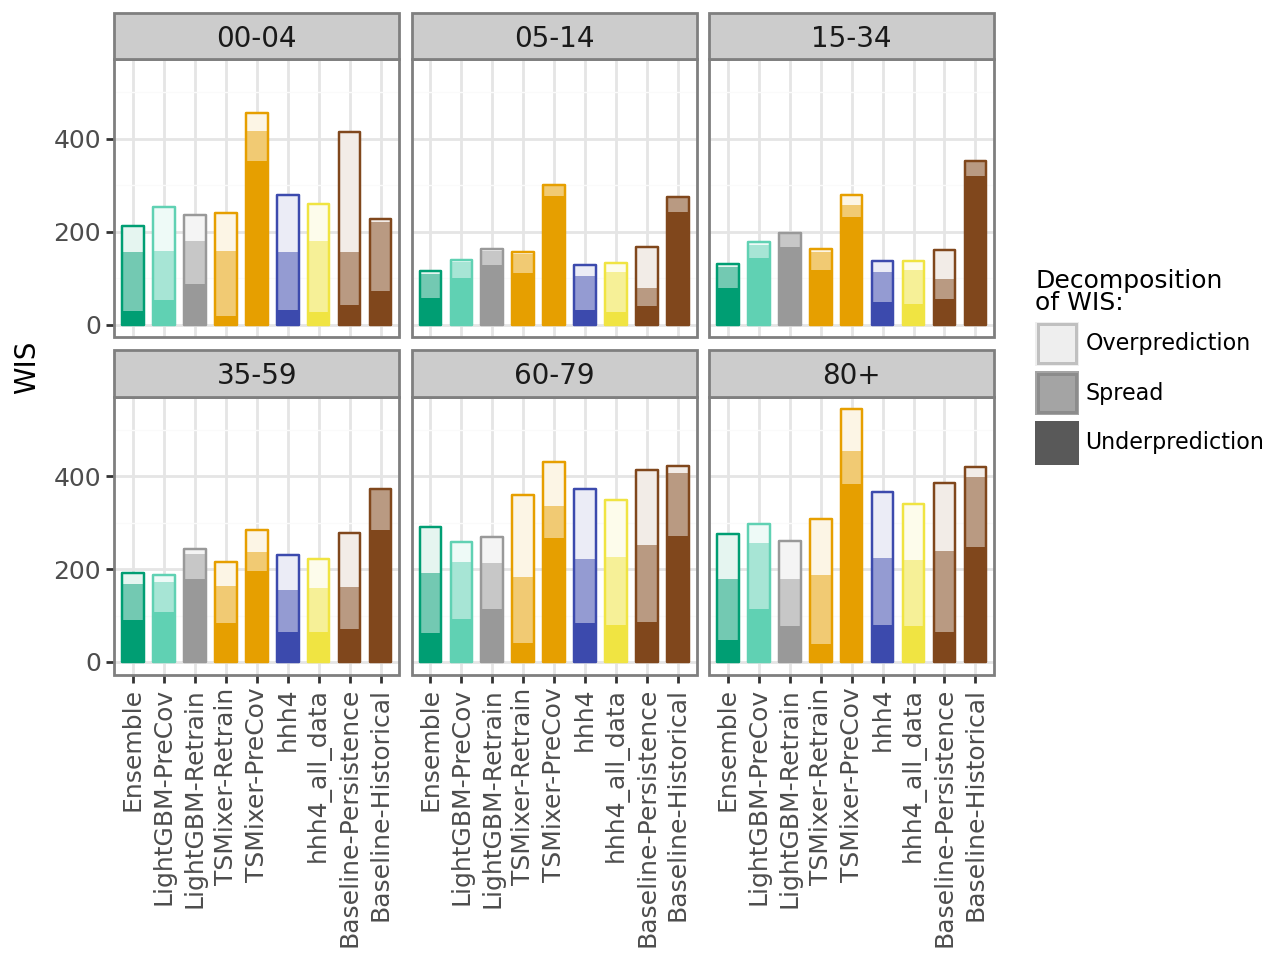

In [32]:
p = plot_scores_by_age_group(scores_age)
p

In [163]:
p.save("../figures/wis_age.pdf", width = 160, height = 110, units="mm", dpi=600)

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 160.0 x 110.00000000000001 mm image.
/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../figures/wis_age.pdf
